# Decision Transformer

In [27]:
import torch
import torch.nn as nn
from torch.nn import functional as F

In [78]:
class CausalSelfAttention(nn.Module):
    def __init__(self, embed_dim, n_head, max_seq_len, dropout=0.1):
        super().__init__()
        self.q_linear = nn.Linear(embed_dim, embed_dim)
        self.k_linear = nn.Linear(embed_dim, embed_dim)
        self.v_linear = nn.Linear(embed_dim, embed_dim)
        self.attn_drop = nn.Dropout(dropout)
        self.out_linear = nn.Linear(embed_dim, embed_dim)
        self.out_drop = nn.Dropout(dropout)
        self.n_head = n_head
        self.max_seq_len = max_seq_len
        self.register_buffer('mask', torch.tril(torch.ones(max_seq_len, max_seq_len)))

    def forward(self, x):
        B, T, E = x.shape
        assert T <= self.max_seq_len, f"The sequence length cannot be larger than {self.max_seq_len}"
        H = self.n_head
        
        q = self.q_linear(x)
        k = self.k_linear(x)
        v = self.v_linear(x)

        D = E // H
        q = q.view(B, T, H, D).transpose(1, 2)  # B, H, T, D
        k = k.view(B, T, H, D).transpose(1, 2)  # B, H, T, D
        v = v.view(B, T, H, D).transpose(1, 2)  # B, H, T, D

        attn = q @ k.transpose(-1, -2) / D ** 0.5
        attn = attn.masked_fill(self.mask[:T, :T] == 0, -float('inf'))  # B, H, T, T
        attn = F.softmax(attn, dim=-1)
        y = self.attn_drop(attn) @ v  # B, H, T, D

        y = y.transpose(1, 2).contiguous().view(B, T, E)
        y = self.out_drop(self.out_linear(y))
        return y

In [86]:
class MLP(nn.Module):
    def __init__(self, embed_size, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(embed_size, 4 * embed_size)
        self.gelu = nn.GELU()
        self.linear2 = nn.Linear(4 * embed_size, embed_size)
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        y = self.linear1(x)
        y = self.gelu(y)
        y = self.linear2(y)
        y = self.drop(y)
        return y

In [89]:
class Block(nn.Module):
    def __init__(self, embed_size, n_head, max_seq_len, dropout=0.1):
        super().__init__()
        self.ln1 = nn.LayerNorm(embed_size)
        self.att_block = CausalSelfAttention(embed_size, n_head, max_seq_len, dropout=dropout)
        self.ln2 = nn.LayerNorm(embed_size)
        self.mlp = MLP(embed_size, dropout=dropout)

    def forward(self, x):
        x = self.ln1(x)
        x = x + self.att_block(x)
        x = self.ln2(x)
        x = x + self.mlp(x)
        return x

In [248]:
class DecisionTransformer(nn.Module):
    def __init__(self, obs_dim, act_dim, embed_size, n_head, n_blocks, max_seq_len, max_timesteps=4096, dropout=0.1):
        super().__init__()
        self.embed_size = embed_size
        self.obs_embedding = nn.Linear(obs_dim, embed_size)
        self.act_embedding = nn.Linear(act_dim, embed_size)
        self.rtg_embedding = nn.Linear(1, embed_size)
        self.time_embedding = nn.Embedding(max_timesteps, embed_size)
        block_size = 3 * max_seq_len
        blocks = [CausalSelfAttention(embed_size, n_head, block_size, dropout=dropout) for _ in range(n_blocks)]
        self.transformer = nn.Sequential(*blocks)
        self.act_head = nn.Sequential(nn.Linear(embed_size, act_dim), nn.Tanh())
        self.obs_head = nn.Sequential(nn.Linear(embed_size, obs_dim), nn.Tanh())
        self.rtg_head = nn.Linear(embed_size, 1)

    def forward(self, t, obs, act, rtg):
        """
        Args:
          t   - B, T
          obs - B, T, obs_dim
          act - B, T, act_dim
          rtg - B, T, 1
        """
        B, T = t.shape
        time_embed = self.time_embedding(t)   # B, T, d
        obs_embed = self.obs_embedding(obs) + time_embed  # B, T, d
        act_embed = self.act_embedding(act) + time_embed  # B, T, d
        rtg_embed = self.rtg_embedding(rtg) + time_embed  # B, T, d

        # convert the sequence into r0, s0, a0, r1, s1, a1, ...
        seq_embed = torch.stack((rtg_embed, obs_embed, act_embed), dim=2).view(B, 3 * T, -1)  # B, 3xT, d

        # NOTE: transformer blocks implement pre layer norm, hence no need to do layer norm again here.
        
        # h[:, 0, t, :] are embeddings based on r0, s0, a0, ..., rt
        # h[:, 1, t, :] are embeddings based on r0, s0, a0, ..., rt, st
        # h[:, 2, t, :] are embeddings based on r0, s0, 10, ..., rt, st, at
        h = self.transformer(seq_embed).view(B, T, 3, -1).transpose(1, 2) # B, 3, T, d

        # predict action from state
        pred_act = self.act_head(h[:, 1])

        # predict state and return are based on action
        pred_return = self.rtg_head(h[:, 2])
        pred_obs = self.obs_head(h[:, 2])
        return pred_act, pred_obs, pred_return

In [244]:
obs_dim = 3
act_dim = 2
embed_size = 32
n_head = 4
n_blocks = 1
max_seq_len = 10

dt = DecisionTransformer(obs_dim, act_dim, embed_size, n_head, n_blocks, max_seq_len)

In [245]:
T = 10
B = 5
t = torch.arange(T).repeat(B, 1)
obs = torch.randn(B, T, obs_dim)
act = torch.randn(B, T, act_dim)
rtg = torch.randn(B, T, 1)

In [246]:
t.shape

torch.Size([5, 10])

In [247]:
pred_act, pred_obs, pred_rtg = dt(t, obs, act, rtg)

torch.Size([5, 10, 32])
torch.Size([5, 30, 32])
torch.Size([5, 30, 32])


In [218]:
pred_act.shape

torch.Size([5, 10, 2])

# Conv3D

In [288]:
x = np.arange(9).reshape(3, 3)

In [290]:
x

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [289]:
x[::2, ::2]

array([[0, 2],
       [6, 8]])

In [296]:
def conv3d(x, kernel, padding=0, stride=1, dilation=1):
    B, C, H, W = x.shape
    k1, k2, k3 = kernel.shape

    if dilation > 1:
        dilated_kernel = np.zeros(((k1 - 1) * dilation + 1, (k2 - 1) * dilation + 1, (k3 - 1) * dilation + 1))
        dilated_kernel[::dilation, ::dilation, ::dilation] = kernel
        kernel = dilated_kernel
        k1, k2, k3 = kernel.shape

    x = np.pad(x, [(0, 0), (padding, padding), (padding, padding), (padding, padding)])
    Cout = (C + 2 * padding - k1) // stride + 1
    Hout = (H + 2 * padding - k2) // stride + 1
    Wout = (W + 2 * padding - k3) // stride + 1
    out = np.zeros((B, Cout, Hout, Wout))
    for b in range(B):
        for i in range(Cout):
            for j in range(Hout):
                for k in range(Wout):
                    out[b, i, j, k] = np.sum(x[b, i : i + k1, j : j + k2, k : k + k3] * kernel)
    return out

In [297]:
x = np.random.randn(5, 3, 10, 10)
kernel = np.random.randn(2, 3, 3)

In [298]:
y = conv3d(x, kernel)

In [300]:
y.shape

(5, 2, 8, 8)

# Linear Regression

In [301]:
import numpy as np

In [368]:
N = 1000
d = 5

w_actual = np.arange(5)
b_actual = 2.0
theta_actual = np.concat((w_actual, [b_actual]))
X = np.random.randn(N, d)
y = (X @ w_actual.reshape(-1, 1)).squeeze() + b_actual + 0.01 * np.random.randn(N)

In [369]:
def predict(X, theta):
    N, d = X.shape
    X = np.concat((X, np.ones((N, 1))), axis=1)
    # print(X)
    return (X @ theta.reshape(-1, 1)).squeeze()

In [370]:
def compute_loss(y, y_pred):
    return ((y - y_pred) ** 2).mean()

In [371]:
def grad(y, y_pred, X):
    N, d = X.shape
    X = np.concat((X, np.ones((N, 1))), axis=1)
    # y - y_pred: N * 1
    # X: N * (d + 1)
    g = 2 * ((y - y_pred).reshape(-1, 1) * (-X)).mean(axis=0)  # (d+1, )
    return g

In [372]:
import matplotlib.pyplot as plt

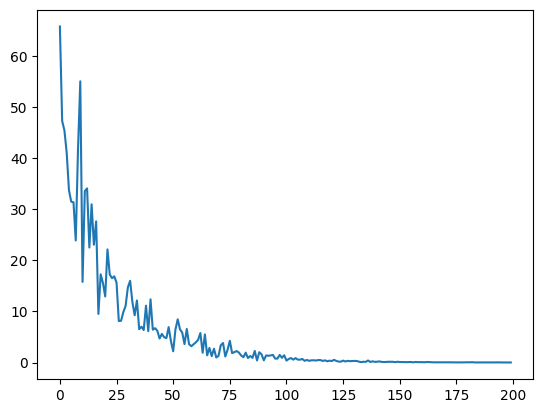

In [373]:
theta = np.random.randn(d + 1)
B = 20

steps = 200
lr = 1e-2

losses = []
for i in range(steps):
    idx = np.random.choice(np.arange(N), size=B)
    y_batch = y[idx]
    X_batch = X[idx, :]

    y_pred = predict(X_batch, theta)
    # print(y_pred)
    loss = compute_loss(y_batch, y_pred)
    theta = theta - lr * grad(y_batch, y_pred, X_batch)
    losses.append(loss)

plt.plot(losses)

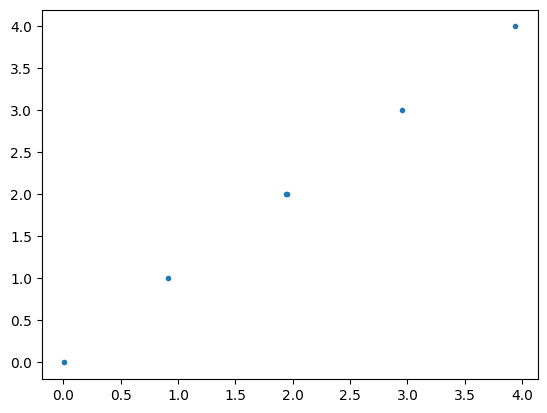

In [375]:
plt.plot(theta, theta_actual, '.')

In [376]:
theta

array([0.00898021, 0.91640744, 1.94663781, 2.95315192, 3.93852638,
       1.94009543])

In [377]:
theta_actual

array([0., 1., 2., 3., 4., 2.])

# Softmax

$Softmax(x_i) = \frac{\exp(x_i)}{\sum_j \exp(x_j)}$

In [379]:
def softmax(x, dim=-1):
    exp_x = np.exp(x)
    sum_exp_x = exp_x.sum(axis=dim, keepdims=True)
    return exp_x / sum_exp_x

In [381]:
x = np.random.randn(10, 5)

In [386]:
y = softmax(x, dim=0)

In [388]:
y.sum(axis=0, keepdims=True)

array([[1., 1., 1., 1., 1.]])

In [389]:
y

array([[0.04872898, 0.03235893, 0.02621826, 0.04493025, 0.07291312],
       [0.0168494 , 0.06874067, 0.03753025, 0.07160909, 0.13267702],
       [0.02825471, 0.0830508 , 0.0163771 , 0.02289387, 0.14609818],
       [0.07800152, 0.02705464, 0.29074718, 0.03414137, 0.0284455 ],
       [0.02545841, 0.41262244, 0.07193617, 0.02656332, 0.05928634],
       [0.04695699, 0.02304539, 0.05752312, 0.36875725, 0.21467786],
       [0.07715349, 0.14674067, 0.12735202, 0.03414291, 0.13046148],
       [0.44638237, 0.14071905, 0.10733467, 0.03132424, 0.11341008],
       [0.04173699, 0.00948332, 0.13475645, 0.35591059, 0.09143086],
       [0.19047714, 0.05618409, 0.13022479, 0.00972711, 0.01059956]])

In [394]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [392]:
yt = F.softmax(torch.as_tensor(x), dim=0)

In [393]:
torch.testing.assert_close(torch.as_tensor(y), yt)

In [396]:
sm = nn.Softmax(dim=0)

In [397]:
yt1 = sm(torch.as_tensor(x))

In [399]:
torch.testing.assert_close(yt, torch.as_tensor(y))

In [400]:
y.sum(axis=0)

array([1., 1., 1., 1., 1.])

In [401]:
y

array([[0.04872898, 0.03235893, 0.02621826, 0.04493025, 0.07291312],
       [0.0168494 , 0.06874067, 0.03753025, 0.07160909, 0.13267702],
       [0.02825471, 0.0830508 , 0.0163771 , 0.02289387, 0.14609818],
       [0.07800152, 0.02705464, 0.29074718, 0.03414137, 0.0284455 ],
       [0.02545841, 0.41262244, 0.07193617, 0.02656332, 0.05928634],
       [0.04695699, 0.02304539, 0.05752312, 0.36875725, 0.21467786],
       [0.07715349, 0.14674067, 0.12735202, 0.03414291, 0.13046148],
       [0.44638237, 0.14071905, 0.10733467, 0.03132424, 0.11341008],
       [0.04173699, 0.00948332, 0.13475645, 0.35591059, 0.09143086],
       [0.19047714, 0.05618409, 0.13022479, 0.00972711, 0.01059956]])

# KMeans

In [420]:
import numpy as np
import matplotlib.pyplot as plt

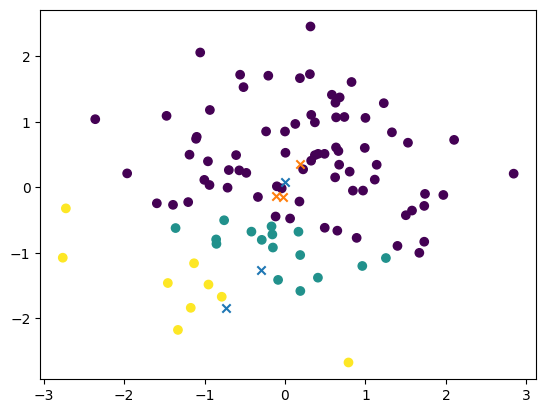

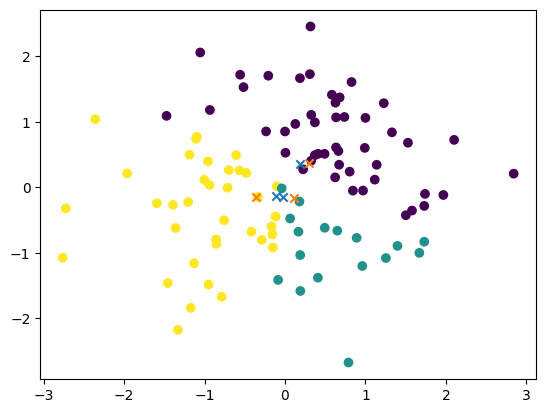

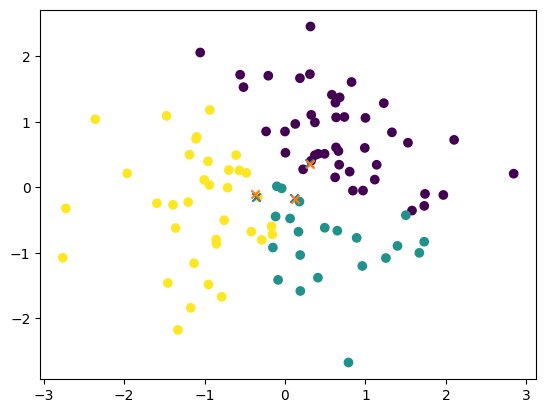

In [433]:
N = 100
d = 2
x = np.random.randn(N, d)
k = 3
centroids = np.random.randn(k, d)
diff = float('inf')
eps = 1e-3
max_iter = 10
i = 0
while i < max_iter and diff > eps:
    distance = ((centroids.reshape(k, 1, d) - x.reshape(1, N, d)) ** 2).mean(axis=-1)  # k, N
    group_idx = np.argmin(distance, axis=0) # N, 
    mask = np.arange(k) == group_idx[:, None]
    new_centroids = (mask.reshape(N, k, 1) * x.reshape(N, 1, d)).mean(axis=0)

    plt.figure()
    plt.scatter(x[:, 0], x[:, 1], c=group_idx)
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='x')
    plt.scatter(new_centroids[:, 0], new_centroids[:, 1], marker='x')
    
    diff = ((new_centroids - centroids)**2).mean()
    centroids = new_centroids
    i += 1
    

# Numpy

In [428]:
import numpy as np

In [432]:
np.array([1, 2, 3, 4], ndmin=2)

array([[1, 2, 3, 4]])

# Logistic Regression

In [13]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [3]:
def grad_sigmoid(x):
    return np.diag(sigmoid(x) * (1 - sigmoid(x)))

In [4]:
def linear(x, theta):
    """
    x - N, d
    theta - d + 1, 

    Returns:
    y - N, 
    """
    N, d = x.shape
    p, = theta.shape
    assert p == d + 1
    x = np.concat((x, np.ones((N, 1))), axis=1)
    return (x @ theta).squeeze()

In [5]:
def grad_linear(x):
    N, d = x.shape
    return np.concat((x, np.ones((N, 1))), axis=1)

In [6]:
def compute_loss(y, logits):
    """
    y - N, 
    logits - N, 
    """
    return - (y * np.log(sigmoid(logits)) + (1 - y) * np.log(1 - sigmoid(logits))).mean()

In [7]:
def loss_grad(y, logits):
    N = y.size
    return - (y - sigmoid(logits)) / N

In [8]:
from sklearn.datasets import load_iris
x, y = load_iris(return_X_y=True)
y = y == 1

In [10]:
x.shape

(150, 4)

In [11]:
y

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

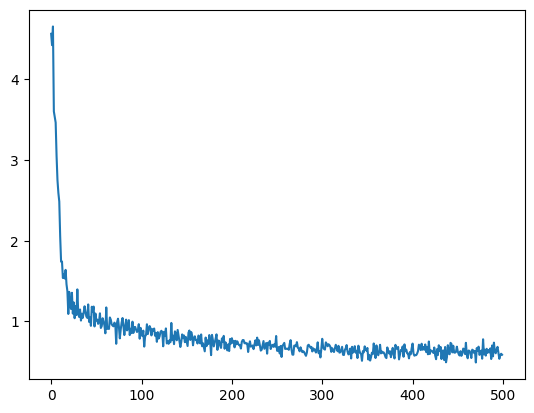

In [18]:
# N = 1000
# d = 3
# x = np.random.randn(N, d)
# y = np.random.randint(0, 2, size=N)
N, d = x.shape
theta = np.random.randn(d + 1)
lr = 1e-2
batch_size = 50

iters = 500

losses = []
for i in range(iters):
    batch_idx = np.random.choice(np.arange(N), size=batch_size)
    x_batch = x[batch_idx, :]
    y_batch = y[batch_idx]
    # print(x_batch)
    logits = linear(x_batch, theta)
    loss = compute_loss(y_batch, logits)
    grad = loss_grad(y_batch, logits) @ grad_linear(x_batch)
    
    theta = theta - lr * grad
    losses.append(loss)
    # print(f"iter {i}: {loss}")

plt.plot(losses)

# Grad

In [ ]:
import torch

In [20]:
N = 10
d = 3
x = torch.randn(N, d)
theta = torch.randn(d, requires_grad=True)

In [21]:
theta

tensor([ 0.4841, -0.6432, -0.0329], requires_grad=True)

In [23]:
y = x @ theta

In [24]:
y

tensor([-0.2019, -0.1515, -0.0587,  0.5121,  1.9065,  1.4405, -0.9580, -0.4554,
        -0.3189,  0.1296], grad_fn=<MvBackward0>)

In [26]:
loss = y.mean()

In [27]:
loss.backward()

In [29]:
theta.grad

tensor([-0.0430, -0.2914, -0.5404])

In [30]:
mean_grad = 1 / N * torch.ones(N)

In [32]:
y.retain_grad()

In [33]:
y.grad

In [34]:
theta.grad

tensor([-0.0430, -0.2914, -0.5404])

In [35]:
linear_grad = x

In [36]:
mean_grad @ linear_grad

tensor([-0.0430, -0.2914, -0.5404])

# Auto Diff

In [15]:
from graphviz import Digraph

In [51]:
def draw_graph(root):
    nodes = set()
    edges = set()
    def build(root):
        nodes.add(root)
        for ch in root._children:
            edges.add((ch, root))
            if ch not in nodes:
                build(ch)
    build(root)

    dot = Digraph('compute-graph', graph_attr={'rankdir': 'LR'})
    for n in nodes:
        dot.node(str(id(n)), f"{{{n.label} | data: {n.data:.3f} | grad: {n.grad:.3f}}}", shape='record')
        if n._op:
            dot.node(str(id(n)) + n._op, n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for a, b in edges:
        dot.edge(str(id(a)), str(id(b)) + b._op)
    return dot
            

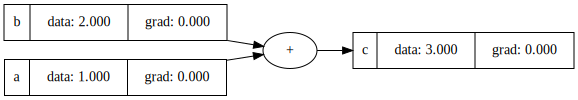

In [52]:
draw_graph(c)

In [95]:
class Value:
    def __init__(self, data, children=[], op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._children = children
        self._op = op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

    def __add__(self, other):
        out = Value(self.data + other.data, children=[self, other], op='+')
        def backward():
            self.grad += out.grad
            other.grad += out.grad

        out._backward = backward
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, children=[self, other], op='*')
        def backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = backward
        return out

    def backward(self):
        visited = set()
        sorted_nodes = []
        def topo_sort(root):
            for ch in root._children:
                if ch not in visited:
                    visited.add(ch)
                    topo_sort(ch)
            sorted_nodes.append(root)

        topo_sort(self)
        self.grad = 1.0
        for node in sorted_nodes[::-1]:
            node._backward()

In [96]:
a = Value(1, label='a')
b = Value(2, label='b')
c = a + b; c.label = 'c'
d = b * c; d.label = 'd'

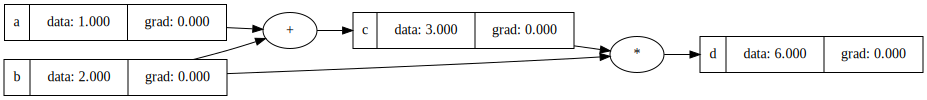

In [97]:
draw_graph(d)

In [98]:
d.backward()

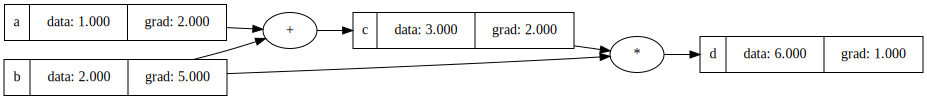

In [99]:
draw_graph(d)

# Softmax and Multiclass Cross Entropy Loss

In [101]:
import numpy as np

In [107]:
def softmax(x, axis=-1):
    # x: B, C
    # return B, C
    exp = np.exp(x)   # B, C
    exp_sum = exp.sum(axis=axis, keepdims=True)  # B, 1
    return exp / exp_sum

In [196]:
N = 10
C = 3

logits = np.random.randn(N, C)  # N, C
y_pred = softmax(logits)
y = np.random.randint(0, C, size=(10,))
loss_np = -((np.arange(C) == y[:, None]) * np.log(y_pred)).sum() / N

In [197]:
np.arange(C) == y[:, None]   # N, C

array([[ True, False, False],
       [ True, False, False],
       [ True, False, False],
       [False,  True, False],
       [ True, False, False],
       [False,  True, False],
       [ True, False, False],
       [False, False,  True],
       [False, False,  True],
       [False,  True, False]])

In [198]:
np.log(y_pred)

array([[-1.7086181 , -1.19065989, -0.66385343],
       [-2.03708245, -0.37245501, -1.71174353],
       [-0.72297724, -1.78031706, -1.0609984 ],
       [-1.74465005, -1.5804808 , -0.47897528],
       [-0.5957516 , -1.10536547, -2.13908985],
       [-0.16843753, -2.68414724, -2.44487987],
       [-2.48264304, -0.90423106, -0.67016384],
       [-1.15001251, -0.67652191, -1.74305462],
       [-2.7335186 , -0.45003928, -1.21265477],
       [-0.42195244, -1.80034608, -1.72040811]])

In [199]:
import torch
import torch.nn as nn

In [200]:
sftmax = nn.Softmax(dim=-1)

In [201]:
cross_entropy = nn.CrossEntropyLoss(reduction='mean')

In [202]:
loss = cross_entropy(torch.as_tensor(logits, dtype=torch.float32), torch.as_tensor(y, dtype=torch.long))

In [209]:
torch.testing.assert_close(loss, torch.as_tensor(loss_np, dtype=torch.float32))